<a href="https://colab.research.google.com/github/imanuelot/sentiment_analysis_iphone/blob/main/iphone_final_tdk_smote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas as pd
import numpy as np
import kagglehub
import os
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#load datasets
df = kagglehub.dataset_download("mrmars1010/iphone-customer-reviews-nlp")
print("Path to dataset files:", df)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data_file = os.path.join(df, "iphone.csv")
df = pd.read_csv(data_file)

100%|██████████| 350k/350k [00:00<00:00, 42.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mrmars1010/iphone-customer-reviews-nlp/versions/1


In [ ]:
#MISSING VALUE
# Hapus missing di kolom penting sebelum proses lanjutan
df = df.dropna(subset=['reviewTitle', 'reviewDescription'])

# Salin data asli sebelum bersih total
df_raw = df.copy()

# Gabungkan teks dan buat label
df['reviewText'] = df['reviewTitle'] + " " + df['reviewDescription']
df['sentiment'] = df['ratingScore'].apply(lambda x: 1 if x >= 4 else 0)

# Tampilkan jumlah missing per kolom (debugging)
print("Jumlah missing per kolom:")
print(df.isnull().sum())

# Simpan jumlah data sebelum penghapusan total missing
jumlah_awal = len(df)

# Bersihkan semua baris yang memiliki missing di kolom manapun
df_clean = df.dropna()

# Cek jumlah data setelah dibersihkan
jumlah_akhir = len(df_clean)
jumlah_dihapus = jumlah_awal - jumlah_akhir

# Hitung jumlah label
label_negatif = df_clean['sentiment'].value_counts().get(0, 0)
label_positif = df_clean['sentiment'].value_counts().get(1, 0)

Jumlah missing per kolom:
productAsin           0
country               0
date                  0
isVerified            0
ratingScore           0
reviewTitle           0
reviewDescription     0
reviewUrl            16
reviewedIn            0
variant               0
variantAsin           0
reviewText            0
sentiment             0
dtype: int64


In [ ]:
results = pd.DataFrame({
    'Jumlah Data': [jumlah_akhir],
    'Jumlah Missing Values Awal': [df_raw.isnull().sum().sum()],
    'Jumlah Missing Values Akhir': [df_clean.isnull().sum().sum()],
    'Jumlah Label negatif': [label_negatif],
    'Jumlah Label positif': [label_positif]
})

display(results)

,Jumlah Data,Jumlah Missing Values Awal,Jumlah Missing Values Akhir,Jumlah Label negatif,Jumlah Label positif
0,2960,16,0,981,1979


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
1,1994
0,982


In [ ]:
#LABEL ENCODING
# Encode label (misalnya: 'positif' → 1, 'negatif' → 0)
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

/tmp/ipython-input-7-308426412.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=['red', 'green'])


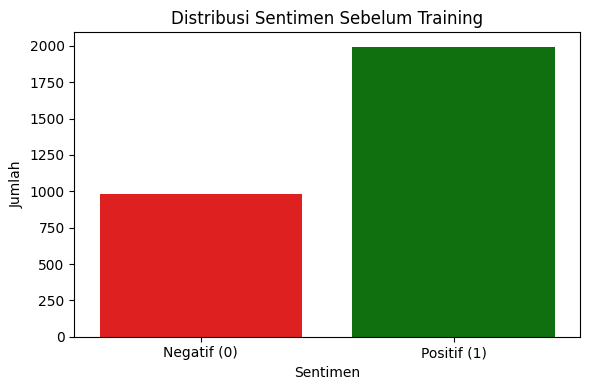

In [ ]:
label_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=['red', 'green'])
plt.title("Distribusi Sentimen Sebelum Training")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah")
plt.xticks([0, 1], ["Negatif (0)", "Positif (1)"])
plt.tight_layout()
plt.show()

In [ ]:
# Split data menjadi training dan testing
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['reviewText'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42
)

In [ ]:
#TOKENISASI
#load tokenizer & model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")

#ekstraksi fitur
def extract_features(text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Mengambil embedding dari CLS token

# Proses training dan testing features
train_features = np.array([extract_features([text]) for text in train_texts])
train_features = train_features.reshape(train_features.shape[0], -1)

test_features = np.array([extract_features([text]) for text in test_texts])
test_features = test_features.reshape(test_features.shape[0], -1)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train XGBoost
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_clf.fit(train_features, train_labels)

# Evaluasi pada data training
train_preds = xgb_clf.predict(train_features)
test_preds = xgb_clf.predict(test_features)

print("\nXGBoost Accuracy on Training Data:", accuracy_score(train_labels, train_preds))
print("Classification Report (Training):\n", classification_report(train_labels, train_preds))

# Evaluasi pada data testing
print("\nXGBoost Accuracy on Test Data:", accuracy_score(test_labels, test_preds))
print("Classification Report (Test):\n", classification_report(test_labels, test_preds))


XGBoost Accuracy on Training Data: 0.9974789915966387
Classification Report (Training):
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       800
           1       1.00      1.00      1.00      1580

    accuracy                           1.00      2380
   macro avg       1.00      1.00      1.00      2380
weighted avg       1.00      1.00      1.00      2380


XGBoost Accuracy on Test Data: 0.9194630872483222
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.92      0.81      0.86       182
           1       0.92      0.97      0.94       414

    accuracy                           0.92       596
   macro avg       0.92      0.89      0.90       596
weighted avg       0.92      0.92      0.92       596



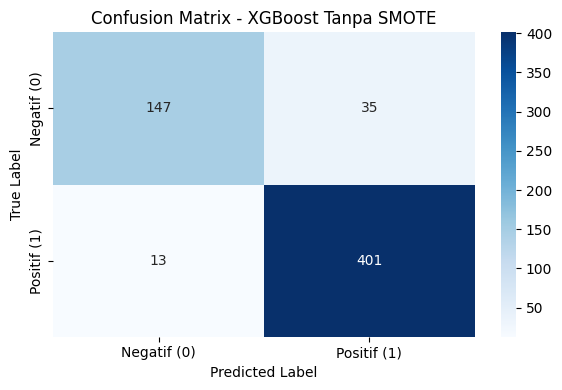

In [ ]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negatif (0)", "Positif (1)"],
            yticklabels=["Negatif (0)", "Positif (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost Tanpa SMOTE")
plt.tight_layout()
plt.show()